[View in Colaboratory](https://colab.research.google.com/github/kevimwe/CAPSTONE/blob/master/Traffic_Signs_Starter_Project.ipynb)

In [137]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [138]:
!ls german-traffic-signs/

signnames.csv  test.p  train.p	valid.p


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Model
np.random.seed(0)
import pickle
import random
import cv2

In [0]:
np.random.seed(0)


In [0]:
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)

In [142]:
print(type(train_data))
x_train, y_train = train_data['features'], train_data['labels']
x_val, y_val = val_data['features'], val_data['labels']
x_test, y_test = test_data['features'], test_data['labels']

<class 'dict'>


In [143]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [0]:
#checking image sizes and dimensions to make sure they are the same
assert(x_train.shape[0]==y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(x_test.shape[0]==y_test.shape[0]), "The number of images is not equal to the number of labels"
assert(x_val.shape[0]==y_val.shape[0]), "The number of images is not equal to the number of labels"
assert(x_train.shape[1:]==(32, 32, 3)), "The dimension of the image are not 32 x 32 x 3"
assert(x_test.shape[1:]==(32, 32, 3)), "The dimension of the image are not 32 x 32 x 3"
assert(x_val.shape[1:]==(32, 32, 3)), "The dimension of the image are not 32 x 32 x 3"

In [145]:
data = pd.read_csv('german-traffic-signs/signnames.csv')


print(data)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

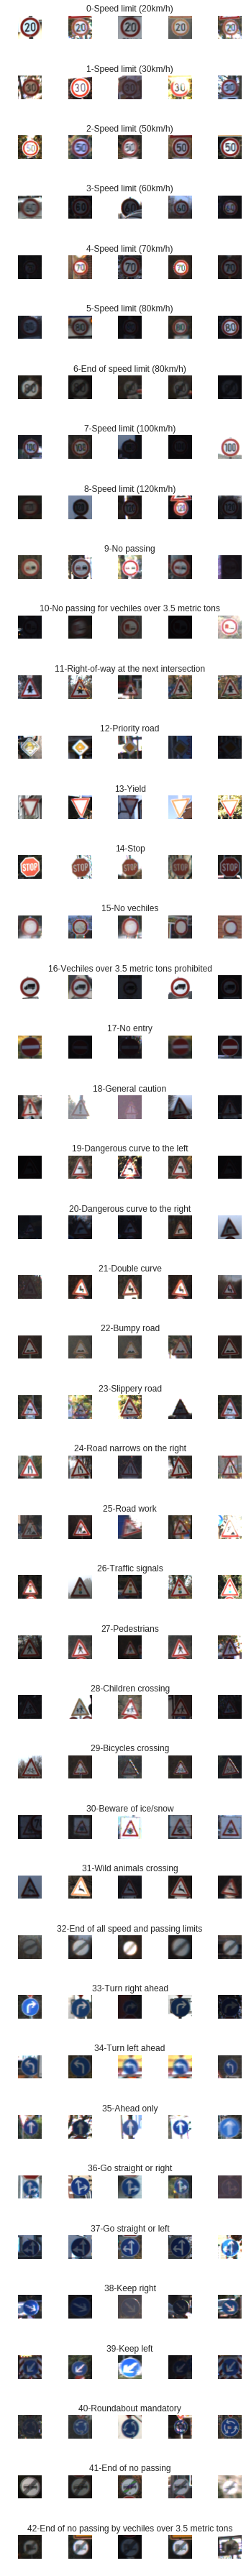

In [146]:
num_of_samples = []
 
cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()
for i in range(cols):
    for j ,row in data.iterrows():
        x_selected = x_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected - 1)), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j)+ "-"+ row["SignName"])
            num_of_samples.append(len(x_selected))
  #(index, Series)

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0,0.5,'Number of images')

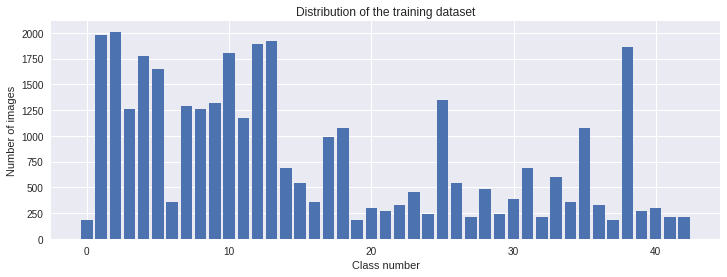

In [147]:
#class distribution
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")

In [0]:
# pre processing the data

(32, 32, 3)
36


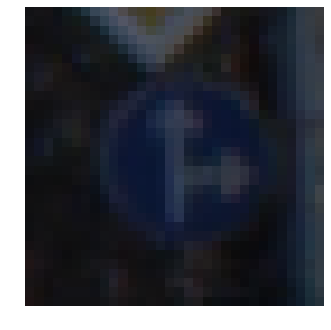

In [149]:
#select a random image to visualize
import cv2 #preprocessing images
plt.imshow(x_train[1000])
plt.axis("off")
print(x_train[1000].shape) #shape
print(y_train[1000]) #label


(32, 32)


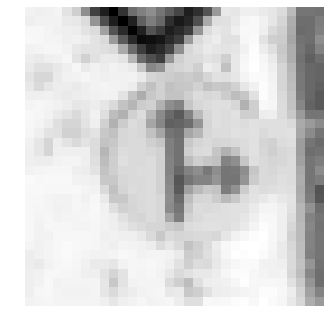

In [150]:
#grayscale conversion function
def grayscale(img):
  img  = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(x_train[1000])
plt.imshow(img)
plt.axis('off')
print(img.shape)

In [0]:
#Histogram equalization
#Aims to standardize the lighting in all the image

(32, 32)


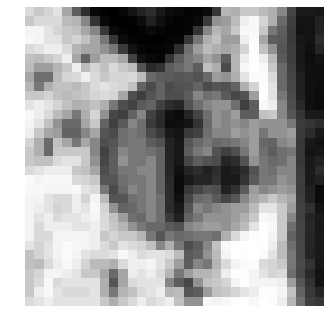

In [152]:
def equalize(img):
  img = cv2.equalizeHist(img)
  return img

img = equalize(img)
plt.imshow(img)
plt.axis('off')
print(img.shape)

In [0]:
def preprocessing(img):
  img =grayscale(img) #grayscale
  img =equalize(img)  #histogramEqualization
  img =img/255#Normalize
  return img

x_train =np.array(list(map(preprocessing, x_train)))
x_val =np.array(list(map(preprocessing, x_val)))
x_test =np.array(list(map(preprocessing, x_test)))

(32, 32)


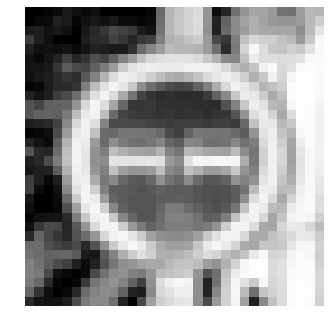

In [154]:
# plot some random images to verify preprocessing
plt.imshow(x_train[random.randint(0, len(x_train)-1)])
plt.axis("off")
print(x_train[random.randint(0, len(x_train)-1)].shape)

In [0]:
#add a depth
x_train = x_train.reshape(34799,32,32,1)
x_test = x_test.reshape(12630,32,32,1)
x_val  =x_val.reshape(4410,32,32,1)

### data augumatiom (model improvement technique)

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range =0.1,
                             height_shift_range =0.1,
                             zoom_range = 0.2,
                             shear_range = 0.1,
                             rotation_range =10)
datagen.fit(x_train)

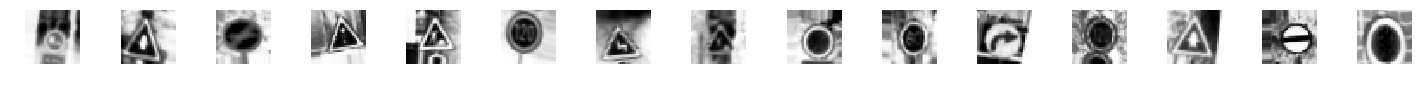

In [157]:
#generate and plot the augumented images
batches = datagen.flow(x_train, y_train, batch_size =20)
x_batch, y_batch =next(batches)

fig, axs =plt.subplots(1,15, figsize = (20, 5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(x_batch[i].reshape(32,32))
  axs[i].axis('off')

In [158]:
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)



(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


In [0]:
#one hot encoding

y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

###  leNET Implemenataion

In [0]:
#define LeNet_Model function
# define the larger model
def leNet_model():
  # create model
  model = Sequential()
  model.add(Conv2D(30, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(15, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5)) #dropout not used on test. turns some nodes on and off
  model.add(Dense(num_classes, activation='softmax'))
  # Compile model
  model.compile(Adam(lr = 0.01), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [0]:
def Modified_leNet_model():
  # create model
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5),  activation='relu'))
  
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  #model.add(Dropout(0.5))
  
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5)) #dropout not used on test. turns some nodes on and off
  model.add(Dense(num_classes, activation='softmax'))
  # Compile model
  model.compile(Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [162]:
model = Modified_leNet_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 480)               0         
__________

In [165]:
#history =model.fit(x_train, y_train, epochs=10,  validation_data = (x_val, y_val), batch_size = 400, verbose = 1, shuffle = 1)

#augumented data
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=50),
                            steps_per_epoch=2000,
                            epochs=10,
                            validation_data=(x_val, y_val), shuffle = 1)

Epoch 1/10
2000/2000 [==============================] - 55s 28ms/step - loss: 0.8951 - acc: 0.7385 - val_loss: 0.1047 - val_acc: 0.9646
Epoch 2/10
2000/2000 [==============================] - 54s 27ms/step - loss: 0.2269 - acc: 0.9299 - val_loss: 0.0575 - val_acc: 0.9807
Epoch 3/10
2000/2000 [==============================] - 55s 27ms/step - loss: 0.1487 - acc: 0.9540 - val_loss: 0.0465 - val_acc: 0.9857
Epoch 4/10
2000/2000 [==============================] - 54s 27ms/step - loss: 0.1205 - acc: 0.9622 - val_loss: 0.0408 - val_acc: 0.9891
Epoch 5/10
2000/2000 [==============================] - 55s 28ms/step - loss: 0.1018 - acc: 0.9686 - val_loss: 0.0370 - val_acc: 0.9882
Epoch 6/10
2000/2000 [==============================] - 54s 27ms/step - loss: 0.0882 - acc: 0.9731 - val_loss: 0.0335 - val_acc: 0.9889
Epoch 7/10
2000/2000 [==============================] - 54s 27ms/step - loss: 0.0779 - acc: 0.9759 - val_loss: 0.0651 - val_acc: 0.9864
Epoch 8/10
2000/2000 [==========================

Text(0.5,0,'epoch')

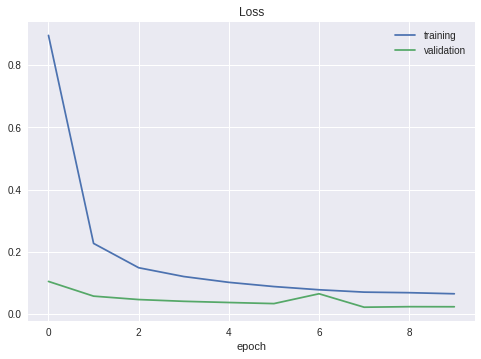

In [166]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')
 

Text(0.5,0,'epoch')

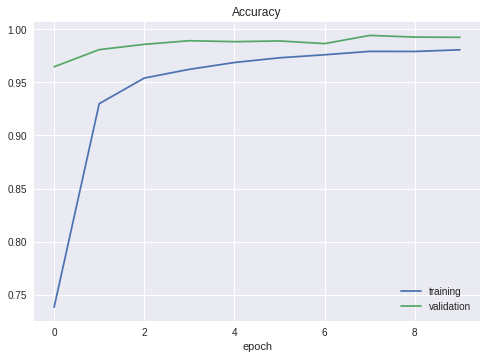

In [167]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

Model is overfitting as the validation accruacy is below the training accuracy. This can be improved using dropout layers

In [168]:
score = model.evaluate(x_test, y_test, verbose=0)
 
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.09538444522045157
Test accuracy: 0.9755344418524186


## Fine Tuning our Network

In [0]:
#1. Speficing initial learning rate that is much smaller
#2.  increaing the number of filters
#3. adding more convolution layers
#4. dropout layers added to solve over fitting

#see modified model above

## Evaluation our model with images from the net

In [0]:
#image urls
url1 = "https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg"

url2 = "https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg"

url3 = "https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg"

url4 = "https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg"

url5 = "https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg"

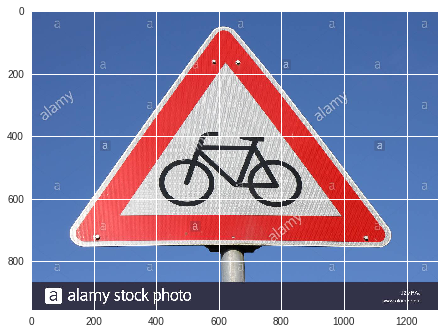

In [170]:
#fetch image
 
import requests
from PIL import Image
url =url5
#url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


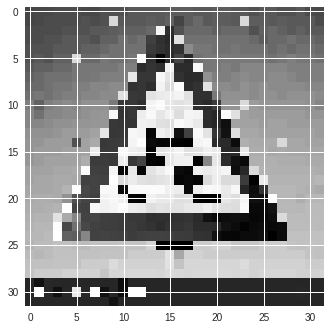

In [171]:
#Preprocess image
 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [172]:
#Reshape reshape
 
img = img.reshape(1, 32, 32, 1)
 
#Test image
print("predicted sign: "+ str(model.predict_classes(img)))

predicted sign: [20]


###  Data agumenation to improve model performance